### Train/Dev/Test sets
Dev and Test sets should contain the most recent data.

TODO: 
- normalize count.
- train on 2014, dev and test on 2015.

Since the count per grid and datetime is proportional to the set size, normalize count or use equally sized train/dev/test sets without normalizing counts.
For a more sophisticated solution (but unnecessarily so?), one could use the empirical distribution of counts to scale counts according to the set size.
So what data should the deployed model be trained on?

### Random Forest Model
Parameters to tune:
- max depth
- training set size

2014-2016-small: 
    - 11m16s to prepare data; 5m1s to train.
    - Used about 4GB for training.
    - R-squared = 0.44 without parameter tuning.
(Lenovo X1 Carbon; i5; 8GB RAM)

2015-2015 small:
    - 6m49s to prepare data; 2m41s to train.

TODO: 
- (Important) Weekday and Hour are categorical!
- Analyze the prediction. Residual by temperature, precipitation, weekday, hour. Accuracy for high-demand area.
- fix read_metar. Only getting <200,000 out of 500,000 after joining. Warning: this bug might skew the data.

Ref:
- http://www.vivekchoksi.com/papers/taxi_pickups.pdf
    Tune the max depth and min records in a leaf.
    


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from utils import geoutils
from utils import datautils

pd.options.mode.chained_assignment = None

/home/atkm/code/taxi-demand-prediction/venv/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [1]:
# Given (year, month) tuples, computes np.arrays for ML
# No memory issue for 2014-2016.
def prep_for_ml(ym_tuples, size):
    X = np.empty((0,6))
    y = np.empty(0)

    for year, month in ym_tuples:
        print(year,month)
        with datautils.get_rides_data(year,month,size) as f:
            rides = datautils.read_rides(f)
        with datautils.get_metar_data(year,month) as f:
            metar = datautils.read_metar(f)
        joined = datautils.join_rides_metar(rides, metar)
        col_names = joined.columns
        X0, y0 = datautils.extract_ml_features(joined)
        print(len(X0))
        
        # when a DataFrame is concatenated with an np.array, it is casted to an np.array.
        X = np.concatenate([X, X0])
        y = np.concatenate([y, y0])
    print(col_names)
    print(f'{len(X)} samples')
    return X, y

## Model training

In [4]:
%%time

months_2016 = [(2016, m+1) for m in range(6)]
#other_months = [(y, m+1) for y in range(2014, 2016) for m in range(12)]
months_2015 = [(2015, k+1) for k in range(12)]
#ym_tuples = other_months + months_2016
ym_tuples = months_2015 + months_2016

# TODO: hour and weekday should be categorical. Implement this when porting the model to Spark.
X, y = prep_for_ml(ym_tuples, 'small')

2015 1
169398
2015 2
165211
2015 3
175603
2015 4
172449
2015 5
178866
2015 6
171779
2015 7
175558
2015 8
174868
2015 9
172424
2015 10
171699
2015 11
168316
2015 12
171790
2016 1
167400
2016 2
164401
2016 3
172977
2016 4
171317
2016 5
176370
2016 6
171797
Index(['grid_x', 'grid_y', 'count', 'precip_in', 'fahrenheit', 'weekday',
       'hour'],
      dtype='object')
3092223 samples
CPU times: user 6min 39s, sys: 2.32 s, total: 6min 42s
Wall time: 6min 42s


In [5]:
%%time

test_set_size=50000
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,test_size=test_set_size, random_state=2)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

CPU times: user 2min 35s, sys: 1.12 s, total: 2min 36s
Wall time: 2min 37s


In [6]:
rf.score(X_train, y_train), rf.score(X_dev, y_dev), rf.score(X_test, y_test)

(0.8304674284721607, 0.46389161473654555, 0.43839968259980927)

In [7]:
# save model and data
from sklearn.externals import joblib
import os

dirname = './model_2014-2016'

if os.path.exists(dirname):
    raise "The model directory already exists! Sure you want to overwrite?"
else:
    os.makedirs(dirname)
    
joblib.dump(rf, f'{dirname}/rf.pkl')
joblib.dump(X_train, f'{dirname}/X_train.pkl')
joblib.dump(X_dev, f'{dirname}/X_dev.pkl')
joblib.dump(X_test, f'{dirname}/X_test.pkl')
joblib.dump(y_train, f'{dirname}/y_train.pkl')
joblib.dump(y_dev, f'{dirname}/y_dev.pkl')
joblib.dump(y_test, f'{dirname}/y_test.pkl')
#pkld = joblib.load('rf_2015-2016.pkl')

['./model_2014-2016/y_test.pkl']

## Analyze model

In [2]:
from sklearn.externals import joblib

dirname = './model_2015-2016'

rf = joblib.load(f'{dirname}/rf.pkl')
X_train = joblib.load(f'{dirname}/X_train.pkl')
X_dev = joblib.load(f'{dirname}/X_dev.pkl')
X_test = joblib.load(f'{dirname}/X_test.pkl')
y_train = joblib.load(f'{dirname}/y_train.pkl')
y_dev = joblib.load(f'{dirname}/y_dev.pkl')
y_test = joblib.load(f'{dirname}/y_test.pkl')

In [3]:
rf.score(X_train, y_train), rf.score(X_dev, y_dev), rf.score(X_test, y_test)

(0.8303843545891284, 0.4611038801153114, 0.43975471433811336)

In [33]:
rmse_score(rf, X_train, y_train), rmse_score(rf, X_dev, y_dev), rmse_score(rf, X_test, y_test)

(1.0392413405837126, 1.8690826500327224, 1.8790995300529996)

### Residual plots
- tends to underestimate high counts; overestimate low counts.
- Feature vs residual plots look good.

In [8]:
y_pred = rf.predict(X_dev)
residual = y_dev - y_pred

In [22]:
# weekday, hour, grid_x, grid_y, temperature, precipitation
X_dev[:10]

array([[ 2.  , 21.  , 32.  , 51.  , 62.06,  0.  ],
       [ 2.  , 12.  , 39.  , 46.  , 40.1 ,  0.21],
       [ 3.  , 22.  , 23.  , 54.  , 23.  ,  0.  ],
       [ 6.  , 21.  , 20.  , 51.  , 32.  ,  0.  ],
       [ 0.  , 17.  , 33.  , 40.  , 60.08,  0.  ],
       [ 1.  , 12.  , 18.  , 52.  , 78.98,  0.  ],
       [ 0.  , 11.  , 30.  , 49.  , 35.06,  0.  ],
       [ 0.  , 12.  , 24.  , 51.  , 51.08,  0.  ],
       [ 3.  , 15.  , 27.  , 65.  , 46.67,  0.  ],
       [ 1.  , 18.  , 26.  , 52.  , 78.89,  0.  ]])

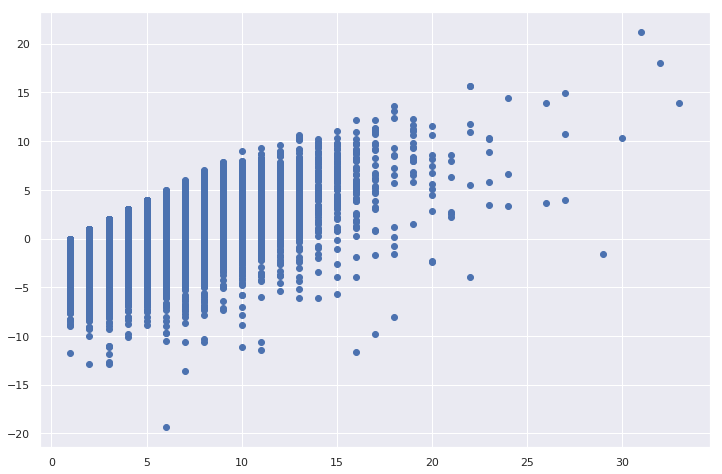

In [11]:
# residual vs actual value
plt.figure(figsize=(12, 8))
plt.scatter(y_dev, residual)

In [29]:
y_dev < 5

array([ True,  True, False, ...,  True,  True, False])

In [28]:
y_pred[y_dev < 5 & residual < 0]

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

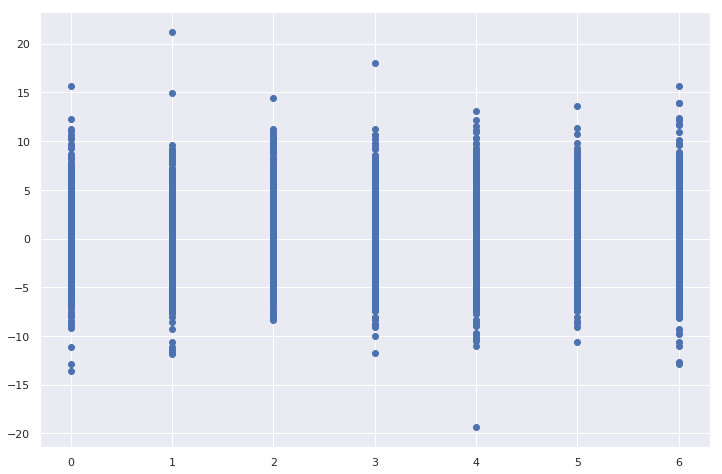

In [23]:
# vs weekday
plt.figure(figsize=(12,8))
plt.scatter(X_dev[:, 0], residual)

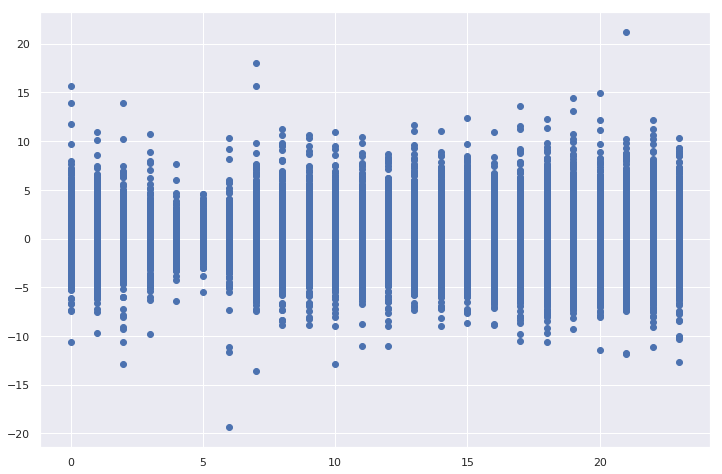

In [24]:
# vs hour
plt.figure(figsize=(12,8))
plt.scatter(X_dev[:, 1], residual)

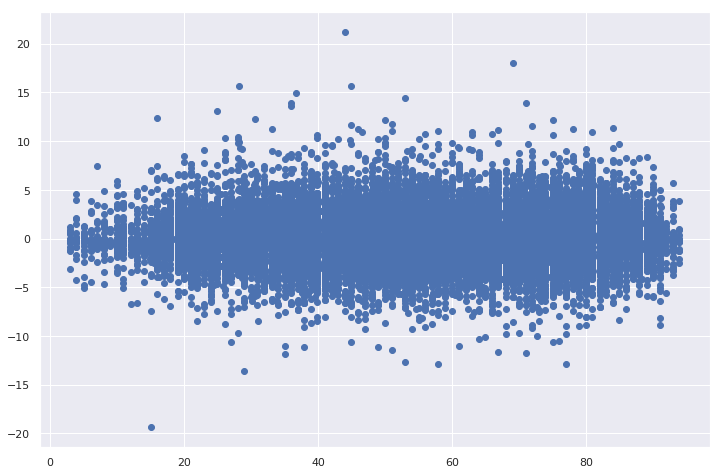

In [25]:
# vs temperature
plt.figure(figsize=(12,8))
plt.scatter(X_dev[:, 4], residual)

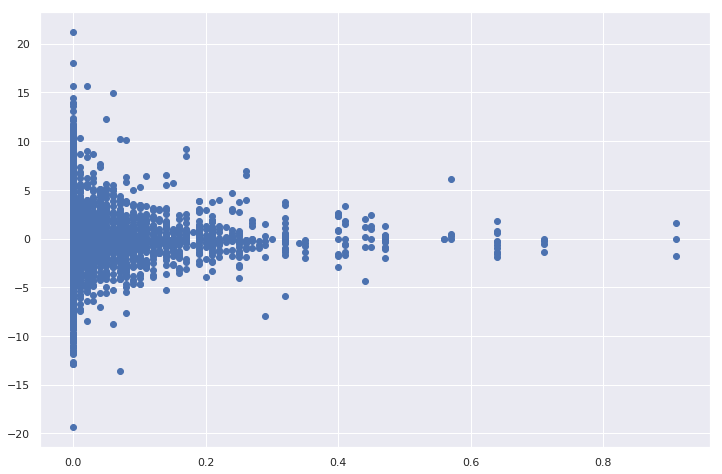

In [20]:
# vs precipitation
plt.figure(figsize=(12,8))
plt.scatter(X_dev[:, 5], residual)

## Train on 2014-2016


In [9]:
X = np.empty((0,6))
y = np.empty(0)

for year, month in ym_tuples:
    print(year,month)
    with datautils.get_rides_data(year,month,'tiny') as f:
        rides = datautils.read_rides(f)
    with datautils.get_metar_data(year,month) as f:
        metar = datautils.read_metar(f)
    X0, y0 = datautils.prep_for_ml(rides, metar)
    col_names = X0.columns
    X = np.concatenate([X, X0])
    y = np.concatenate([y, y0])

print(col_names)

2014 1
2014 2
2014 3
2014 4
2014 5
2014 6
2014 7
2014 8
2014 9
2014 10
2014 11
2014 12
2015 1
2015 2
2015 3
2015 4
2015 5
2015 6
2015 7
2015 8
2015 9
2015 10
2015 11
2015 12
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
Index(['weekday', 'hour', 'grid_x', 'grid_y', 'fahrenheit', 'precip_in'], dtype='object')


In [13]:
X[np.random.randint(X.shape[0], size=10)]

array([[6.0, 0.0, 27.0, 47.0, 75.02, 0.0],
       [0.0, 7.0, 21.0, 56.0, 41.0, 0.0],
       [1.0, 7.0, 27.0, 48.0, 66.02, 0.0],
       [5.0, 2.0, 19.0, 54.0, 68.0, 0.0],
       [5.0, 16.0, 28.0, 55.0, 77.0, 0.0],
       [1.0, 9.0, 29.0, 43.0, 80.06, 0.0],
       [1.0, 21.0, 14.0, 57.0, 77.0, 0.0],
       [1.0, 13.0, 31.0, 48.0, 57.14000000000001, 0.0],
       [0.0, 18.0, 24.0, 49.0, 78.08, 0.0],
       [4.0, 8.0, 40.0, 42.0, 51.08, 0.0]], dtype=object)

In [8]:
year=2014
month=10
with datautils.get_rides_data(year,month,'tiny') as f:
    rides = datautils.read_rides(f)
with datautils.get_metar_data(year,month) as f:
    metar = datautils.read_metar(f)
X, y = datautils.prep_for_ml(rides, metar)

DataError: No numeric types to aggregate

In [3]:
rides.shape, metar.shape

((10000, 3), (671, 3))

In [4]:
X.shape

(9399, 6)

In [3]:
# Note X.values, y.values
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.1, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,test_size=0.1, random_state=2)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_dev, y_dev)

## Develop prep_for_ml
Using 2014-01.

In [112]:
size='small'
rides = datautils.read_rides(f'data/yellow_tripdata_2014-01_{size}.csv')
rides = datautils.clean_rides(rides)
rides['join_datetime'] = pd.to_datetime(rides.pickup_datetime.dt.strftime("%Y-%m-%d %H"))
rides.head()

,pickup_datetime,pickup_longitude,pickup_latitude,join_datetime
0,2014-01-25 01:53:00,-73.979040,40.761767,2014-01-25 01:00:00
1,2014-01-10 22:11:20,-73.776607,40.645137,2014-01-10 22:00:00
2,2014-01-14 19:27:05,-73.981940,40.761639,2014-01-14 19:00:00
3,2014-01-28 13:35:00,-73.970580,40.755682,2014-01-28 13:00:00
4,2014-01-04 21:10:00,-73.983027,40.766362,2014-01-04 21:00:00


In [113]:
# minutes and seconds information are unnecessary.
rides = datautils.add_grid_cols(rides).drop(['pickup_latitude', 'pickup_longitude', 'pickup_datetime'], axis=1)
rides.head()

,join_datetime,grid_x,grid_y
0,2014-01-25 01:00:00,30,47
1,2014-01-10 22:00:00,117,70
2,2014-01-14 19:00:00,29,47
3,2014-01-28 13:00:00,34,48
4,2014-01-04 21:00:00,28,46


In [114]:
#counts = rides.set_index('join_datetime').groupby([pd.Grouper(freq='1H', level='join_datetime'), 'grid_x', 'grid_y']).size()
counts = rides.groupby(['join_datetime', 'grid_x', 'grid_y']).size()
counts = counts.reset_index(name='count')
counts.head() # For an unknown reason, the hour info is implicit in the printed table

,join_datetime,grid_x,grid_y,count
0,2014-01-01,2,53,1
1,2014-01-01,4,51,1
2,2014-01-01,14,58,4
3,2014-01-01,14,59,1
4,2014-01-01,15,56,1


In [115]:
metar = datautils.read_metar('data/metar_data/lga_2014-01.csv')
metar.head()

,datetime,precip_in,fahrenheit
0,2013-12-31 23:00:00,0.0,26.96
1,2014-01-01 00:00:00,0.0,26.06
2,2014-01-01 01:00:00,0.0,24.98
3,2014-01-01 02:00:00,0.0,24.98
4,2014-01-01 03:00:00,0.0,24.98


In [116]:
# since there are hours without weather info, some rides are dropped.
df = pd.merge(counts, metar, left_on='join_datetime', right_on='datetime', how='inner')
df['weekday'] = df.datetime.dt.weekday
df['hour'] = df.datetime.dt.hour
df = df.drop(['join_datetime', 'datetime'], axis=1)
# data ready for model training.
df.head()

,grid_x,grid_y,count,precip_in,fahrenheit,weekday,hour
0,2,53,1,0.0,26.06,2,0
1,4,51,1,0.0,26.06,2,0
2,14,58,4,0.0,26.06,2,0
3,14,59,1,0.0,26.06,2,0
4,15,56,1,0.0,26.06,2,0


In [117]:
# 9866 - 9452 = 414 rides were dropped. For each missing hour, there are several corresponding grid cells.
df_left_join = pd.merge(rides, metar, left_on='join_datetime', right_on='datetime', how='left')
df_left_join.shape, df.shape

((493141, 6), (174027, 7))

In [118]:
features = ['weekday', 'hour', 'grid_x', 'grid_y', 'fahrenheit', 'precip_in']
X = df[features].values
y = df['count'].values

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train,test_size=0.1, random_state=2)

In [120]:
len(X_train), len(X_dev), len(X_test)

(140961, 15663, 17403)

In [121]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf.score(X_dev, y_dev)

0.4664394125855953

In [122]:
y_pred = rf.predict(X_dev)
np.sum(np.square(y_dev - y_pred))

52977.675681816894

In [124]:
dfdf = pd.DataFrame({'true': y_dev, 'pred': y_pred})
dfdf[dfdf['true'] > 20]

,true,pred
738,26,10.40
2508,21,12.60
4832,24,15.20
5250,28,15.71
9326,21,16.41
12945,27,21.60
13026,22,10.90
13580,21,15.20


## Develop read_metar

In [9]:
year=2014
month=10
usecols = ['valid', 'tmpf', ' p01i'] 
metar = pd.read_csv(datautils.get_metar_data(year,month), usecols=usecols)
metar.columns = ['datetime', 'fahrenheit', 'precip_in']
metar['datetime'] = pd.to_datetime(metar['datetime'])
metar.head() # the last record 

,datetime,fahrenheit,precip_in
0,2014-10-01 00:20:00,62.60,0.03
1,2014-10-01 00:36:00,62.60,0.03
2,2014-10-01 00:51:00,62.06,0.03
3,2014-10-01 01:51:00,62.06,0.00
4,2014-10-01 01:58:00,62.60,0.00


In [10]:
precip = metar[['datetime','precip_in']]
precip['month_day'] = precip.datetime.dt.strftime("%m/%d")
precip.groupby('month_day').size()
precip.groupby('month_day').apply(lambda grp: sum(grp.datetime.dt.minute == 51))
# 2nd, 5th, and 31st lost one record.

month_day
10/01    24
10/02    24
10/03    24
10/04    24
10/05    24
10/06    23
10/07    24
10/08    24
10/09    24
10/10    24
10/11    24
10/12    24
10/13    24
10/14    24
10/15    24
10/16    24
10/17    24
10/18    24
10/19    23
10/20    24
10/21    24
10/22    24
10/23    24
10/24    24
10/25    24
10/26    24
10/27    24
10/28    24
10/29    24
10/30    24
10/31    24
dtype: int64

In [32]:
fahrenheit = metar[['datetime', 'fahrenheit']]
fahrenheit.head()

,datetime,fahrenheit
0,2014-10-01 00:20:00,62.60
1,2014-10-01 00:36:00,62.60
2,2014-10-01 00:51:00,62.06
3,2014-10-01 01:51:00,62.06
4,2014-10-01 01:58:00,62.60


In [33]:
fahrenheit = fahrenheit[fahrenheit.fahrenheit.str.match(r'\d+(\.\d+)?')]
fahrenheit['fahrenheit'] = fahrenheit.fahrenheit.astype('float')

In [25]:
def to_float(s):
    try:
        return float(s)
    except:
        raise(s)
fahrenheit.fahrenheit.apply(to_float)

TypeError: exceptions must derive from BaseException

In [13]:
fahrenheit.groupby(['datetime']).mean()

DataError: No numeric types to aggregate

In [26]:
fifth = metar[metar.datetime.dt.day==5]
fifth

,datetime,fahrenheit,precip_in
118,2014-01-05 00:51:00,26.96,0.00
119,2014-01-05 01:51:00,26.96,0.00
120,2014-01-05 02:51:00,26.06,0.00
121,2014-01-05 03:51:00,26.96,0.00
122,2014-01-05 04:51:00,26.06,0.00
123,2014-01-05 05:51:00,26.96,0.00
124,2014-01-05 06:51:00,28.94,0.00
125,2014-01-05 07:51:00,30.02,0.00
126,2014-01-05 08:05:00,30.20,0.00
127,2014-01-05 08:51:00,30.92,0.00


In [27]:
sixth = metar[metar.datetime.dt.day == 6]
sixth.head()

,datetime,fahrenheit,precip_in
165,2014-01-06 00:15:00,50.0,0.00
166,2014-01-06 00:34:00,50.0,0.00
167,2014-01-06 00:47:00,50.0,0.00
168,2014-01-06 00:51:00,50.0,0.03
169,2014-01-06 01:00:00,50.0,0.01


In [24]:
last_day_of_month = metar[metar.datetime.dt.day==31]
last_day_of_month

,datetime,fahrenheit,precip_in
0,2013-12-31 23:51:00,26.96,0.0
905,2014-01-31 00:21:00,26.60,0.0
906,2014-01-31 00:51:00,26.06,0.0
907,2014-01-31 01:11:00,26.60,0.0
908,2014-01-31 01:51:00,26.06,0.0
909,2014-01-31 02:51:00,26.06,0.0
910,2014-01-31 03:51:00,28.04,0.0
911,2014-01-31 04:51:00,28.94,0.0
912,2014-01-31 05:51:00,28.94,0.0
913,2014-01-31 06:51:00,28.94,0.0


In [7]:
metar[metar.datetime.dt.day==2]

,datetime,precip_in,fahrenheit,month_day
25,2014-01-02 00:00:00,0.00,32.00,01/02
26,2014-01-02 01:00:00,0.00,32.00,01/02
27,2014-01-02 02:00:00,0.00,32.00,01/02
28,2014-01-02 03:00:00,0.00,30.02,01/02
29,2014-01-02 04:00:00,0.00,28.22,01/02
30,2014-01-02 05:00:00,0.01,26.96,01/02
31,2014-01-02 06:00:00,0.00,26.96,01/02
32,2014-01-02 07:00:00,0.00,26.96,01/02
33,2014-01-02 08:00:00,0.00,26.96,01/02
34,2014-01-02 09:00:00,0.00,26.96,01/02


In [6]:
metar['month_day'] = metar.datetime.dt.strftime("%m/%d")
metar.groupby('month_day').size()

month_day
01/01    24
01/02    23
01/03    24
01/04    24
01/05    23
01/06    24
01/07    24
01/08    24
01/09    24
01/10    24
01/11    24
01/12    24
01/13    24
01/14    24
01/15    24
01/16    24
01/17    24
01/18    24
01/19    24
01/20    24
01/21    24
01/22    24
01/23    24
01/24    24
01/25    24
01/26    24
01/27    24
01/28    24
01/29    24
01/30    24
01/31    23
12/31     1
dtype: int64